# MARP Results

This notebook reproduces the results of the "MARP" chapter of the manuscript.

In [1]:
# Load the necessary libraries

%load_ext autoreload
%autoreload 2

from hwacctools.comp_graph import splitter, cnodes, cgraph, core
import onnx
from onnx import numpy_helper as nphelp
import numpy as np
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import onnxruntime as ort
from onnx import helper
import hwacctools.onnx_utils as onnx_utils
import pandas as pd
import hwacctools.onnx_tools.onnx_splitter as onnx_splitter
import rectpack
import tqdm
import seaborn as sns

df = pd.DataFrame

def get_packer_string(df_row):
    if df_row['Naive']:
        return 'Naive'
    
    df_row['Offline'] = 'OFF' if df_row['Offline'] else 'ON'
    df_row['SortAlgo'] = '' if df_row['SortAlgo'] == 'SORT_NONE' else df_row['SortAlgo']
    df_row['PackAlgo'] = 'MR' if df_row['PackAlgo'] == 'MaxRectsBssf' else 'SKY'

    return f"{df_row['Offline']}_{df_row['BinAlgo']}_{df_row['PackAlgo']}{df_row['SortAlgo']}"

def get_model_name(df_row):
    return df_row['modelpath'].split('/')[-1].split('.')[0]

## Generate Split Models

Here we generate the split (not necessarily tiled) versions of the ONNX models.
We do this so that the largest layer-equivalent matrices fit in the AIMC core.

To change the core sizes, you can change `C_max` (for the AIMC core rows) and `K_max` (for the AIMC core columns).

These ONNX models are placed into `hwacc_design_garage/onnx_models/*_split.onnx`

This is only done for reference so that we can view them in Netron. For example, [use Netron to inspect the split mbv2 model here](https://netron.app/?url=https://github.com/Lawrence-lugs/hwacc_design_garage/blob/main/onnx_models/mbv2_cifar10_int8_split.onnx).

In [5]:
modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]
for modelpath in modelpaths:
    nx_model = onnx.load(modelpath)
    onnx_splitter.split_model_to_per_channel(
        nx_model.graph,
        C_max = 256,
        K_max = 256,
        dwC_max= 32)
    onnx.save_model(nx_model, modelpath.replace('.onnx', '_split.onnx'))

## Sample MARP Usage

Here's an example of MARP usage.

Here, we don't need to use a pre-split model because `core.NxModelMapping` already takes `core_size` as an argument and it performs the splits internally.


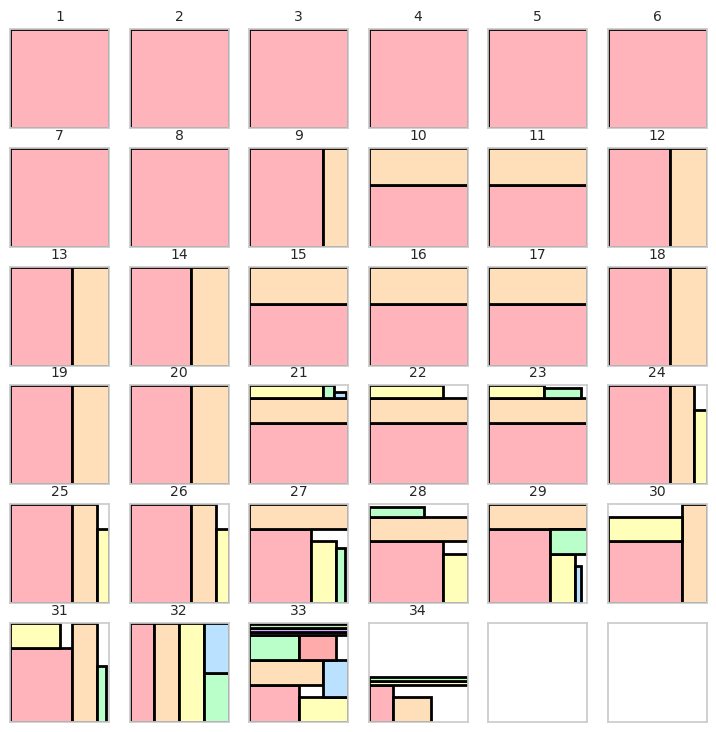

In [23]:
# Define onnx model path
modelpath = 'onnx_models/mbv2_cifar10_int8.onnx'

# Define the packer to use from rectpack
# If packer isn't specified, it will use the Dense packer (MaxRectsBssf with BFF Offline) which is the one here.
packer = rectpack.newPacker(
    mode=rectpack.PackingMode.Offline,
    bin_algo=rectpack.PackingBin.BFF, 
    rotation=False, 
    pack_algo=rectpack.MaxRectsBssf
)

core_size = (256, 256)

nx_model = onnx.load(modelpath)
u_marped = core.NxModelMapping(nx_model, imc_core_size=core_size, packer=packer, naive=False)
u_marped.plot()

In [7]:
# Setup sweeps for packing experiments

from hwacctools.comp_graph import packer_utils as pu

modes = [
    'ON','OFF'
]

modes_dict = {
    'ON': rectpack.PackingMode.Online,
    'OFF': rectpack.PackingMode.Offline
}

bin_heuristic = [
    'BBF','BNF','BFF'
]

bin_heuristic_dict = {
    'BBF': rectpack.PackingBin.BBF,
    'BNF': rectpack.PackingBin.BNF,
    'BFF': rectpack.PackingBin.BFF
}

fit_heuristic = [
    'BAF','BL','BSSF'
]

fit_heuristic_dict = {
    'BAF': rectpack.MaxRectsBaf,
    'BL': rectpack.MaxRectsBl, 
    'BSSF': rectpack.MaxRectsBssf
}

sort_order = [
    'SO', 'SS', 'SF'
]

sort_order_dict = {
    'SO': rectpack.SORT_NONE,
    'SS': rectpack.SORT_SSIDE,
    'SF': rectpack.SORT_PERI
}

core_size = (256, 256)


modelpath = 'onnx_models/mbv2_cifar10_int8.onnx'


results_df = pd.DataFrame(columns=[
    'Mode', 'Bin Heuristic', 'Fit Heuristic', 'Sort Order','Nwrites','Nbins'
])

for mode in modes:
    for bin_algo in bin_heuristic:
        for pack_algo in fit_heuristic:
            for sort_algo in sort_order:
                try:
                    packer = rectpack.newPacker(
                        mode=modes_dict[mode],
                        bin_algo=bin_heuristic_dict[bin_algo], 
                        rotation=False, 
                        pack_algo=fit_heuristic_dict[pack_algo],
                        sort_algo=sort_order_dict[sort_algo]
                    )
                except:
                    print(f"Skipping {modelpath} with bin_algo={bin_algo}, pack_algo={pack_algo}, sort_algo={sort_algo}")
                    continue
                u_marped = core.NxModelMapping(
                    onnx.load(modelpath),
                    imc_core_size=core_size,
                    packer=packer,
                    naive=False
                )
                u_qracc = core.QRAccModel(
                    u_marped,
                    num_cores=1
                )
                results_df.loc[len(results_df)] = {
                    'Mode': mode,
                    'Bin Heuristic': bin_algo,
                    'Fit Heuristic': pack_algo,
                    'Sort Order': sort_algo,
                    'Nwrites': u_qracc.weight_bin_writes,
                    'Nbins': u_qracc.total_bins
                }

results_df


packer is <rectpack.packer.PackerOnlineBBF object at 0x7f9525665f10>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952da76090>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952da76090>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952d6fc5f0>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952d6fc5f0>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952db01250>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952db01250>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f95243f8050>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f95243f8050>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952e8ea630>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952e8ea630>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952d6fc5f0>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952d6fc5f0>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952db38140>
packer is <rectpack.packer.PackerO

,Mode,Bin Heuristic,Fit Heuristic,Sort Order,Nwrites,Nbins
0,ON,BBF,BAF,SO,70,41
1,ON,BBF,BAF,SS,70,41
2,ON,BBF,BAF,SF,70,41
3,ON,BBF,BL,SO,71,41
4,ON,BBF,BL,SS,71,41
5,ON,BBF,BL,SF,71,41
6,ON,BBF,BSSF,SO,71,40
7,ON,BBF,BSSF,SS,71,40
8,ON,BBF,BSSF,SF,71,40
9,ON,BNF,BAF,SO,54,53


/tmp/ipykernel_4008471/1151137111.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = facetgrid._legend.legendHandles, [t.get_text() for t in facetgrid._legend.get_texts()]


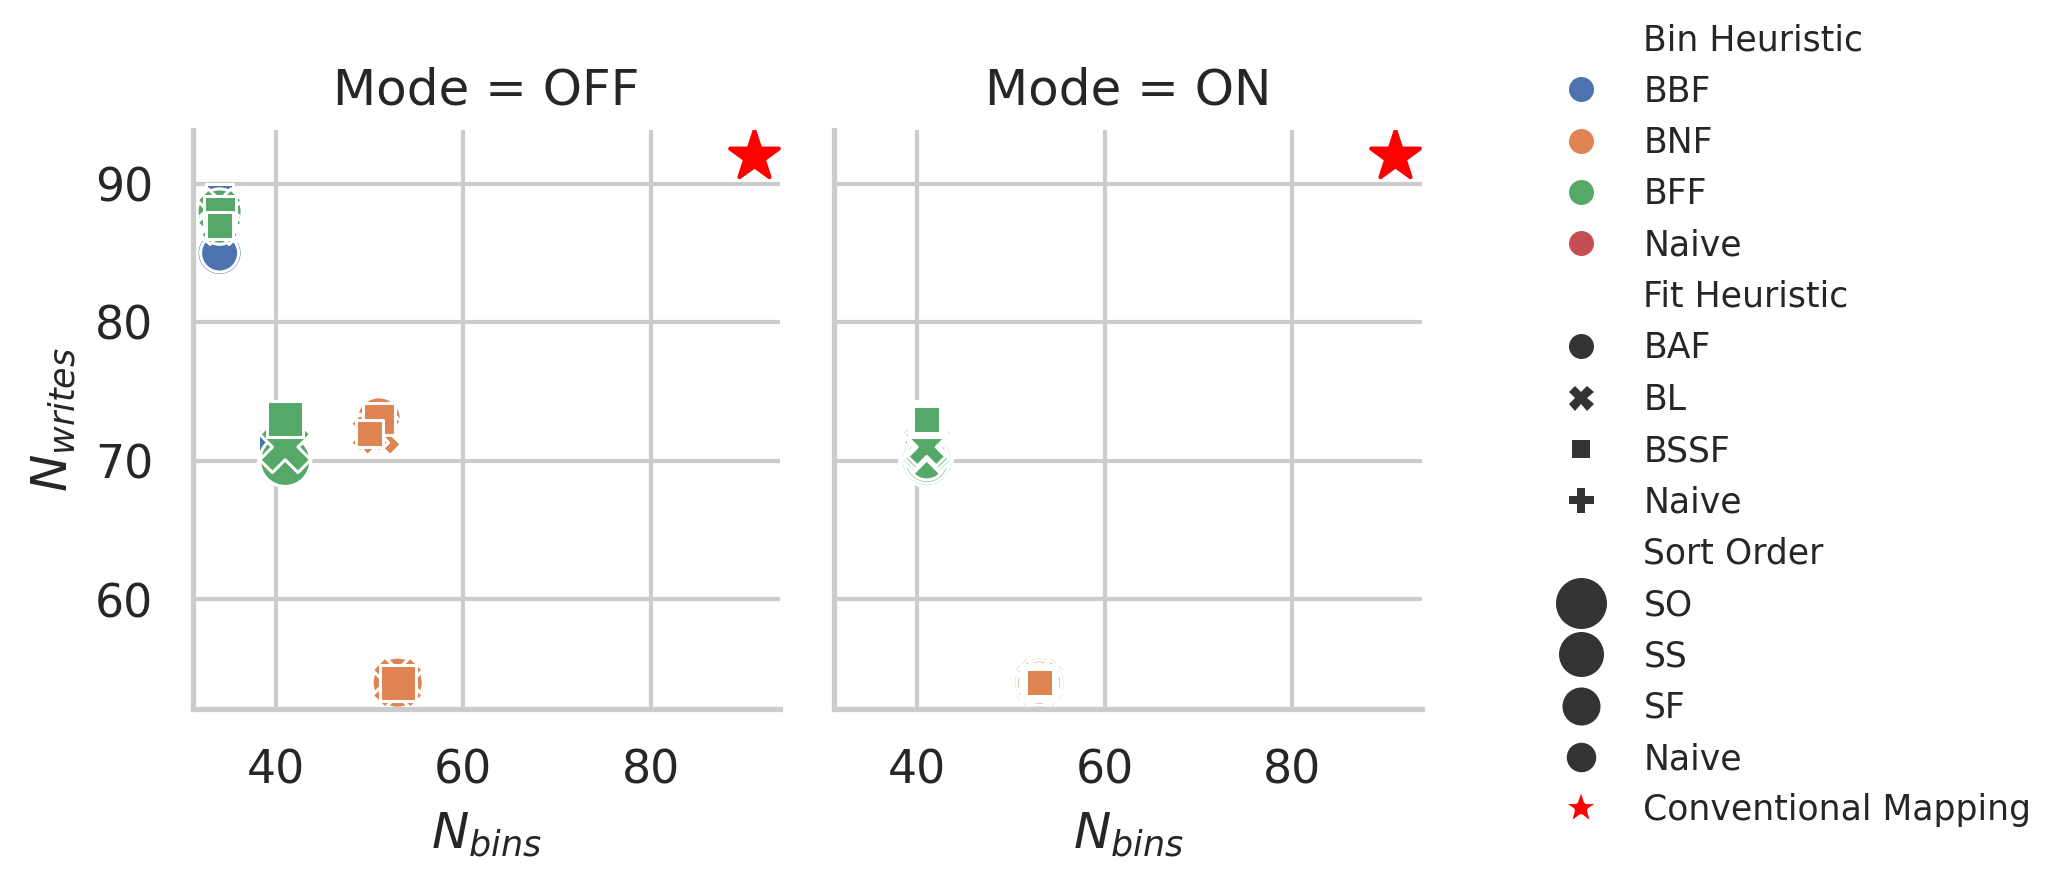

In [10]:
sns.set_theme(style="whitegrid")

# fig,ax = plt.subplots(1,2,figsize=(5, 3), dpi=300)

# OFF must be on the left
results_df['Mode'] = pd.Categorical(results_df['Mode'], categories=['OFF', 'ON'], ordered=True)

facetgrid = sns.relplot(
    data=results_df,
    x='Nbins',
    y='Nwrites',
    hue='Bin Heuristic',
    col='Mode',
    style='Fit Heuristic',
    size='Sort Order',
    sizes=(50,150)
)

# Add new datapoint called Conventional Mapping at 91, 92 with a red star
for ax in facetgrid.axes.flat:
    ax.scatter(91, 92, color='red', marker='*', s=150, label='Conventional Mapping', zorder=10)

# Get the legend from the facet grid and add Conventional Mapping
if facetgrid._legend is not None:
    # Get existing legend handles and labels
    handles, labels = facetgrid._legend.legendHandles, [t.get_text() for t in facetgrid._legend.get_texts()]
    
    # Add Conventional Mapping if not present
    if 'Conventional Mapping' not in labels:
        handles.append(plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=10))
        labels.append('Conventional Mapping')
    
    # Update the legend
    facetgrid._legend.remove()
    facetgrid._legend = facetgrid.fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 1), 
                                           fontsize='x-small', frameon=False)

# set legend outside
facetgrid._legend.set_bbox_to_anchor((1.01, 1))
facetgrid._legend.set_loc('upper left')

# set figsize to 5,3 dpi to 300
facetgrid.fig.set_size_inches(5, 3)
facetgrid.set_axis_labels('$N_{bins}$', '$N_{writes}$')
facetgrid.fig.set_dpi(300)

plt.tight_layout()

In [11]:
# Setup sweeps for packing experiments

from hwacctools.comp_graph import packer_utils as pu

modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]

packer_argument_headers = [
    'Naive','Offline','BinAlgo','PackAlgo','SortAlgo'
]
get_packer_arguments = [
    [True,True,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BNF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BFF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BNF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BFF','MaxRectsBssf','SORT_NONE'],
]
core_sizes = [(256,256),(512,512)]

In [12]:
results = []
with tqdm.tqdm(total=len(modelpaths) * len(core_sizes) * len(get_packer_arguments), desc="Total Progress") as pbar:
    for modelpath in modelpaths:
        for core_size in core_sizes:
            for args in get_packer_arguments:
                packer = pu.get_packer(*args, core_size=core_size)
                nx_model = onnx.load(modelpath)
                u_marped = core.NxModelMapping(nx_model, imc_core_size=core_size, packer=packer)

                if not u_marped.success:
                    print(f"Packing failed for {modelpath} with core size {core_size} and arguments {args}")
                    pbar.update(1)
                    continue

                u_qracc = core.QRAccModel(packed_cgraph=u_marped, num_cores=1)
                results.append({
                    'modelpath': modelpath,
                    'core_size': core_size,
                    'utilization': u_qracc.utilization,
                    'bin_writes': u_qracc.weight_bin_writes,
                    'nbins': u_marped.nbins,
                    **dict(zip(packer_argument_headers, args))
                })
                pbar.update(1)

df = pd.DataFrame(results)
df.to_csv('experiment_results.csv', index=False)

Total Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Total Progress:  21%|██▏       | 12/56 [00:00<00:00, 114.63it/s]

packer is <hwacctools.comp_graph.packer_utils.NaiveRectpackPacker object at 0x7f9525675280>
packer is <rectpack.packer.PackerBBF object at 0x7f952d7aaa20>
packer is <rectpack.packer.PackerBNF object at 0x7f95244f3920>
packer is <rectpack.packer.PackerBFF object at 0x7f952d7a85c0>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f95244f3920>
packer is <rectpack.packer.PackerOnlineBNF object at 0x7f952457d460>
packer is <rectpack.packer.PackerOnlineBFF object at 0x7f9524591040>
packer is <hwacctools.comp_graph.packer_utils.NaiveRectpackPacker object at 0x7f952d7a89b0>
packer is <rectpack.packer.PackerBBF object at 0x7f952dab5580>
packer is <rectpack.packer.PackerBNF object at 0x7f952457f7d0>
packer is <rectpack.packer.PackerBFF object at 0x7f9524591040>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952450d250>
packer is <rectpack.packer.PackerOnlineBNF object at 0x7f95244f3920>
packer is <rectpack.packer.PackerOnlineBFF object at 0x7f9525674b00>
packer is <hwacctools.co

Total Progress:  52%|█████▏    | 29/56 [00:00<00:00, 35.57it/s] 

packer is <rectpack.packer.PackerBBF object at 0x7f95243bef00>
packer is <rectpack.packer.PackerBNF object at 0x7f952d7da510>
packer is <rectpack.packer.PackerBNF object at 0x7f952d7da510>
packer is <rectpack.packer.PackerBFF object at 0x7f9525677b90>
packer is <rectpack.packer.PackerBFF object at 0x7f9525677b90>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952dc4e270>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952dc4e270>
packer is <rectpack.packer.PackerOnlineBNF object at 0x7f952da199a0>
packer is <rectpack.packer.PackerOnlineBNF object at 0x7f952da199a0>
packer is <rectpack.packer.PackerOnlineBFF object at 0x7f952d7a8860>
packer is <rectpack.packer.PackerOnlineBFF object at 0x7f952d7a8860>
packer is <hwacctools.comp_graph.packer_utils.NaiveRectpackPacker object at 0x7f952db38530>
packer is <hwacctools.comp_graph.packer_utils.NaiveRectpackPacker object at 0x7f952db38530>


Total Progress:  64%|██████▍   | 36/56 [00:04<00:03,  5.67it/s]

packer is <rectpack.packer.PackerBBF object at 0x7f95243bd700>
packer is <rectpack.packer.PackerBNF object at 0x7f95244a18b0>
packer is <rectpack.packer.PackerBNF object at 0x7f95244a18b0>
packer is <rectpack.packer.PackerBFF object at 0x7f952da76ae0>
packer is <rectpack.packer.PackerBFF object at 0x7f952da76ae0>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952d8a13a0>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f952d8a13a0>


Total Progress:  71%|███████▏  | 40/56 [00:06<00:03,  4.44it/s]

packer is <rectpack.packer.PackerOnlineBNF object at 0x7f952da199a0>
packer is <rectpack.packer.PackerOnlineBFF object at 0x7f95255c1ee0>
packer is <rectpack.packer.PackerOnlineBFF object at 0x7f95255c1ee0>


Total Progress: 100%|██████████| 56/56 [00:07<00:00,  7.65it/s]

packer is <hwacctools.comp_graph.packer_utils.NaiveRectpackPacker object at 0x7f952458e570>
packer is <rectpack.packer.PackerBBF object at 0x7f9524590d40>
packer is <rectpack.packer.PackerBNF object at 0x7f95243bef00>
packer is <rectpack.packer.PackerBFF object at 0x7f95244a33e0>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f95243bd700>
packer is <rectpack.packer.PackerOnlineBNF object at 0x7f95243be3c0>
packer is <rectpack.packer.PackerOnlineBFF object at 0x7f95243bef00>
packer is <hwacctools.comp_graph.packer_utils.NaiveRectpackPacker object at 0x7f9525675be0>
packer is <rectpack.packer.PackerBBF object at 0x7f952450fc20>
packer is <rectpack.packer.PackerBNF object at 0x7f95243bc6b0>
packer is <rectpack.packer.PackerBFF object at 0x7f95243bd700>
packer is <rectpack.packer.PackerOnlineBBF object at 0x7f95244a0e30>
packer is <rectpack.packer.PackerOnlineBNF object at 0x7f95245930e0>
packer is <rectpack.packer.PackerOnlineBFF object at 0x7f95243be3c0>


In [13]:
df

,modelpath,core_size,utilization,bin_writes,nbins,Naive,Offline,BinAlgo,PackAlgo,SortAlgo
0,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.287946,15,14,True,True,BBF,MaxRectsBssf,SORT_NONE
1,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,7,5,False,True,BBF,MaxRectsBssf,SORT_NONE
2,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,6,5,False,True,BNF,MaxRectsBssf,SORT_NONE
3,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,7,5,False,True,BFF,MaxRectsBssf,SORT_NONE
4,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,7,5,False,False,BBF,MaxRectsBssf,SORT_NONE
5,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,6,5,False,False,BNF,MaxRectsBssf,SORT_NONE
6,onnx_models/ad_quantized_int8.onnx,"(256, 256)",0.806250,7,5,False,False,BFF,MaxRectsBssf,SORT_NONE
7,onnx_models/ad_quantized_int8.onnx,"(512, 512)",0.083984,13,12,True,True,BBF,MaxRectsBssf,SORT_NONE
8,onnx_models/ad_quantized_int8.onnx,"(512, 512)",0.503906,4,2,False,True,BBF,MaxRectsBssf,SORT_NONE
9,onnx_models/ad_quantized_int8.onnx,"(512, 512)",0.503906,3,2,False,True,BNF,MaxRectsBssf,SORT_NONE


In [14]:
df = pd.read_csv('experiment_results.csv')
df['PackerArgs'] = df.apply(get_packer_string, axis=1)
df['ModelName'] = df.apply(get_model_name, axis=1)
df.drop(columns=packer_argument_headers, inplace=True)
df.drop(columns=['modelpath'], inplace=True)

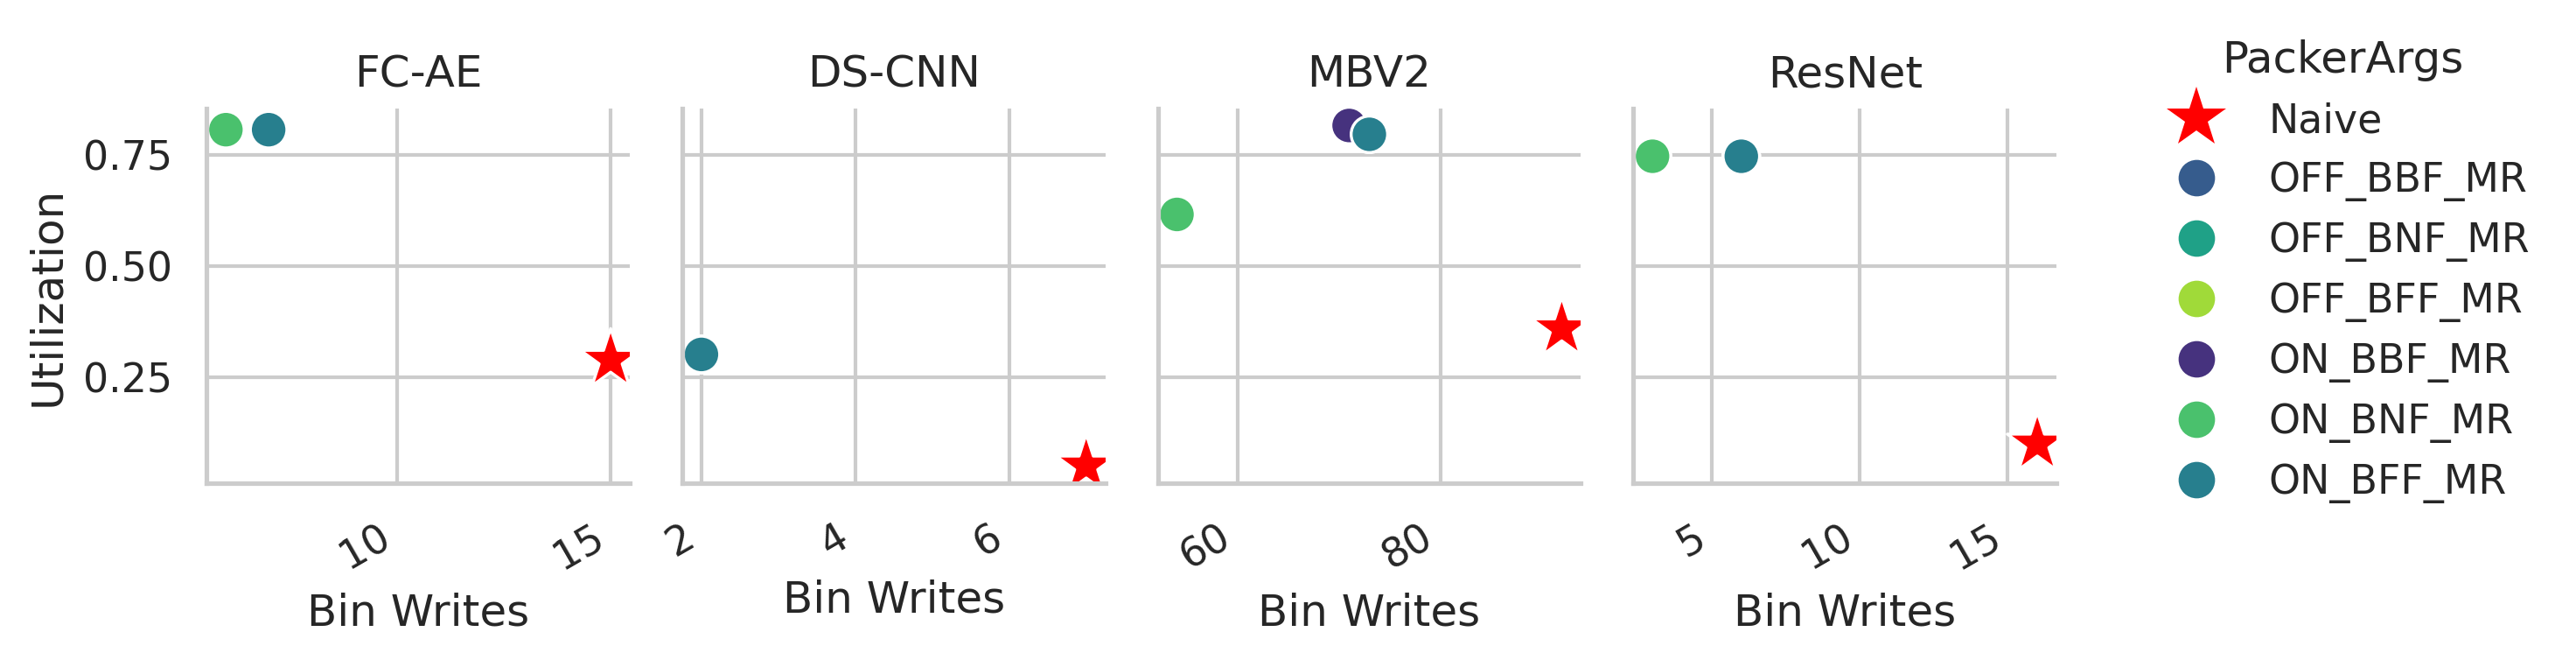

In [15]:
sns.set_theme(style="whitegrid")
# Create a new column for marker and color
df['Marker'] = df['PackerArgs'].apply(lambda x: '*' if x == 'Naive' else 'o')
df['Color'] = df['PackerArgs'].apply(lambda x: 'red' if x == 'Naive' else None)

df = df[df['core_size'] == '(256, 256)']

marker_dict = {
    'Naive': '*',
    'ON_BBF_MR': 'o',
    'OFF_BBF_MR': 'o',
    'ON_BFF_MR': 'o',
    'OFF_BNF_MR': 'o',
    'ON_BNF_MR': 'o',
    'OFF_BFF_MR': 'o'
}

sizes_dict = {
    'Naive': 300,
    'ON_BBF_MR': 100,
    'OFF_BBF_MR': 100,
    'ON_BFF_MR': 100,
    'OFF_BNF_MR': 100,
    'ON_BNF_MR': 100,
    'OFF_BFF_MR': 100
}

# Create a color palette based on viridis, but set 'Naive' to red
viridis_palette = sns.color_palette("viridis", n_colors=len(marker_dict) - 1)
custom_palette = {'Naive': 'red'}
for k, c in zip([k for k in marker_dict if k != 'Naive'], viridis_palette):
    custom_palette[k] = c

# Plot with custom markers and colors
g = sns.relplot(
    data=df,
    x='bin_writes',
    y='utilization',
    col='ModelName',
    row='core_size',
    hue='PackerArgs',
    kind='scatter',
    palette=custom_palette,
    facet_kws={'sharey': True, 'sharex': False},
    size='PackerArgs',
    sizes=sizes_dict,  # use sizes_dict to set marker sizes
    style='PackerArgs',  # use style to distinguish 'Naive'
    markers=marker_dict
)

# Set red color for 'Naive' points
for ax in g.axes.flat:
    for path_collection, label in zip(ax.collections, g._legend_data.keys()):
        if label == 'Naive':
            path_collection.set_color('red')
g.figure.set_size_inches(8, 2.5)
g.figure.set_dpi(300)
plt.tight_layout()

# set legend outside
g._legend.set_bbox_to_anchor((1.01, 1))
g._legend.set_loc('upper left')
# rotate x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')

title_dict = {
    'ad_quantized_int8': 'FC-AE',
    'ks_quantized_int8': 'DS-CNN',
    'mbv2_cifar10_int8': 'MBV2',
    'ic_quantized_int8': 'ResNet',
}

# remove everything before = in the titles
for ax in g.axes.flat:
    ax.set_title(ax.get_title().split('=')[-1].strip())
# set titles
for ax in g.axes.flat:
    ax.set_title(title_dict[ax.get_title()])
# set x labels to 'Bin Writes'
for ax in g.axes.flat:
    ax.set_xlabel('Bin Writes')
# set y labels to 'Utilization'
for ax in g.axes.flat:
    ax.set_ylabel('Utilization')

In [16]:
# Get rows where packer is naive
naive_rows = df[df['core_size'] == '(256, 256)']
naive_rows = naive_rows.sort_values(by='utilization', ascending=False)
# Use model name as index and pivot the core size
naive_rows

ModelNameDict = {
    'ad_quantized_int8': 'FC-AE',
    'ks_quantized_int8': 'DS-CNN',
    'mbv2_cifar10_int8': 'MBV2',
    'ic_quantized_int8': 'ResNet'
}
packerArgsDict = {
    'Naive': 'Naive',
    'OFF_BBF_MR': 'Dense',
    'ON_BBF_MR': 'Balanced',
    'ON_BNF_MR': 'WriteOptimized'
}

# Rename the ModelName column
naive_rows['ModelName'] = naive_rows['ModelName'].apply(lambda x: ModelNameDict.get(x, x))
# Rename the PackerArgs column
naive_rows['PackerArgs'] = naive_rows['PackerArgs'].apply(lambda x: packerArgsDict.get(x, x))
# if the PackerArgs is not in the dict, drop it
naive_rows = naive_rows[naive_rows['PackerArgs'].isin(packerArgsDict.values())]
naive_rows = naive_rows.drop(columns=['core_size'])
naive_rows.set_index(['ModelName', 'PackerArgs'], inplace=True)
naive_rows.rename(columns={'bin_writes': 'Bin Writes', 'utilization': 'Utilization', 'nbins' : '# Bins'}, inplace=True)

# Rename indices to  'ModelName':'Model', 'PackerArgs':'Packer'
naive_rows.index.names = ['Model', 'Packer']
# Sort by ModelName and then by PackerArgs

# sort by ModelName and then by utilization
naive_rows = naive_rows.sort_index(level='Model')
# rename the bin writes column

packer_order = ['Naive', 'Dense', 'Balanced', 'WriteOptimized']
naive_rows = naive_rows.reindex(
    pd.MultiIndex.from_product(
        [naive_rows.index.levels[0], packer_order],
        names=naive_rows.index.names
    ),
    fill_value=np.nan
)

naive_rows.to_csv('naive_mlperftiny.csv')

In [17]:
def get_packer(packername):
    if packername == 'Naive':
        return pu.NaiveRectpackPacker(256, 256)
    elif packername == 'Dense':
        return rectpack.newPacker(
            mode=rectpack.PackingMode.Offline,
            bin_algo=rectpack.PackingBin.BBF, 
            rotation=False, 
            pack_algo=rectpack.MaxRectsBssf
        )
    elif packername == 'Balanced':
        return rectpack.newPacker(
            mode=rectpack.PackingMode.Online,
            bin_algo=rectpack.PackingBin.BBF, 
            rotation=False, 
            pack_algo=rectpack.MaxRectsBssf
        )
    elif packername == 'WriteOptimized':
        return rectpack.newPacker(
            mode=rectpack.PackingMode.Online,
            bin_algo=rectpack.PackingBin.BNF, 
            rotation=False, 
            pack_algo=rectpack.MaxRectsBssf
        )
    else:
        raise ValueError(f"Unknown packer name: {packername}")

packer is <hwacctools.comp_graph.packer_utils.NaiveRectpackPacker object at 0x7f95241f5400>


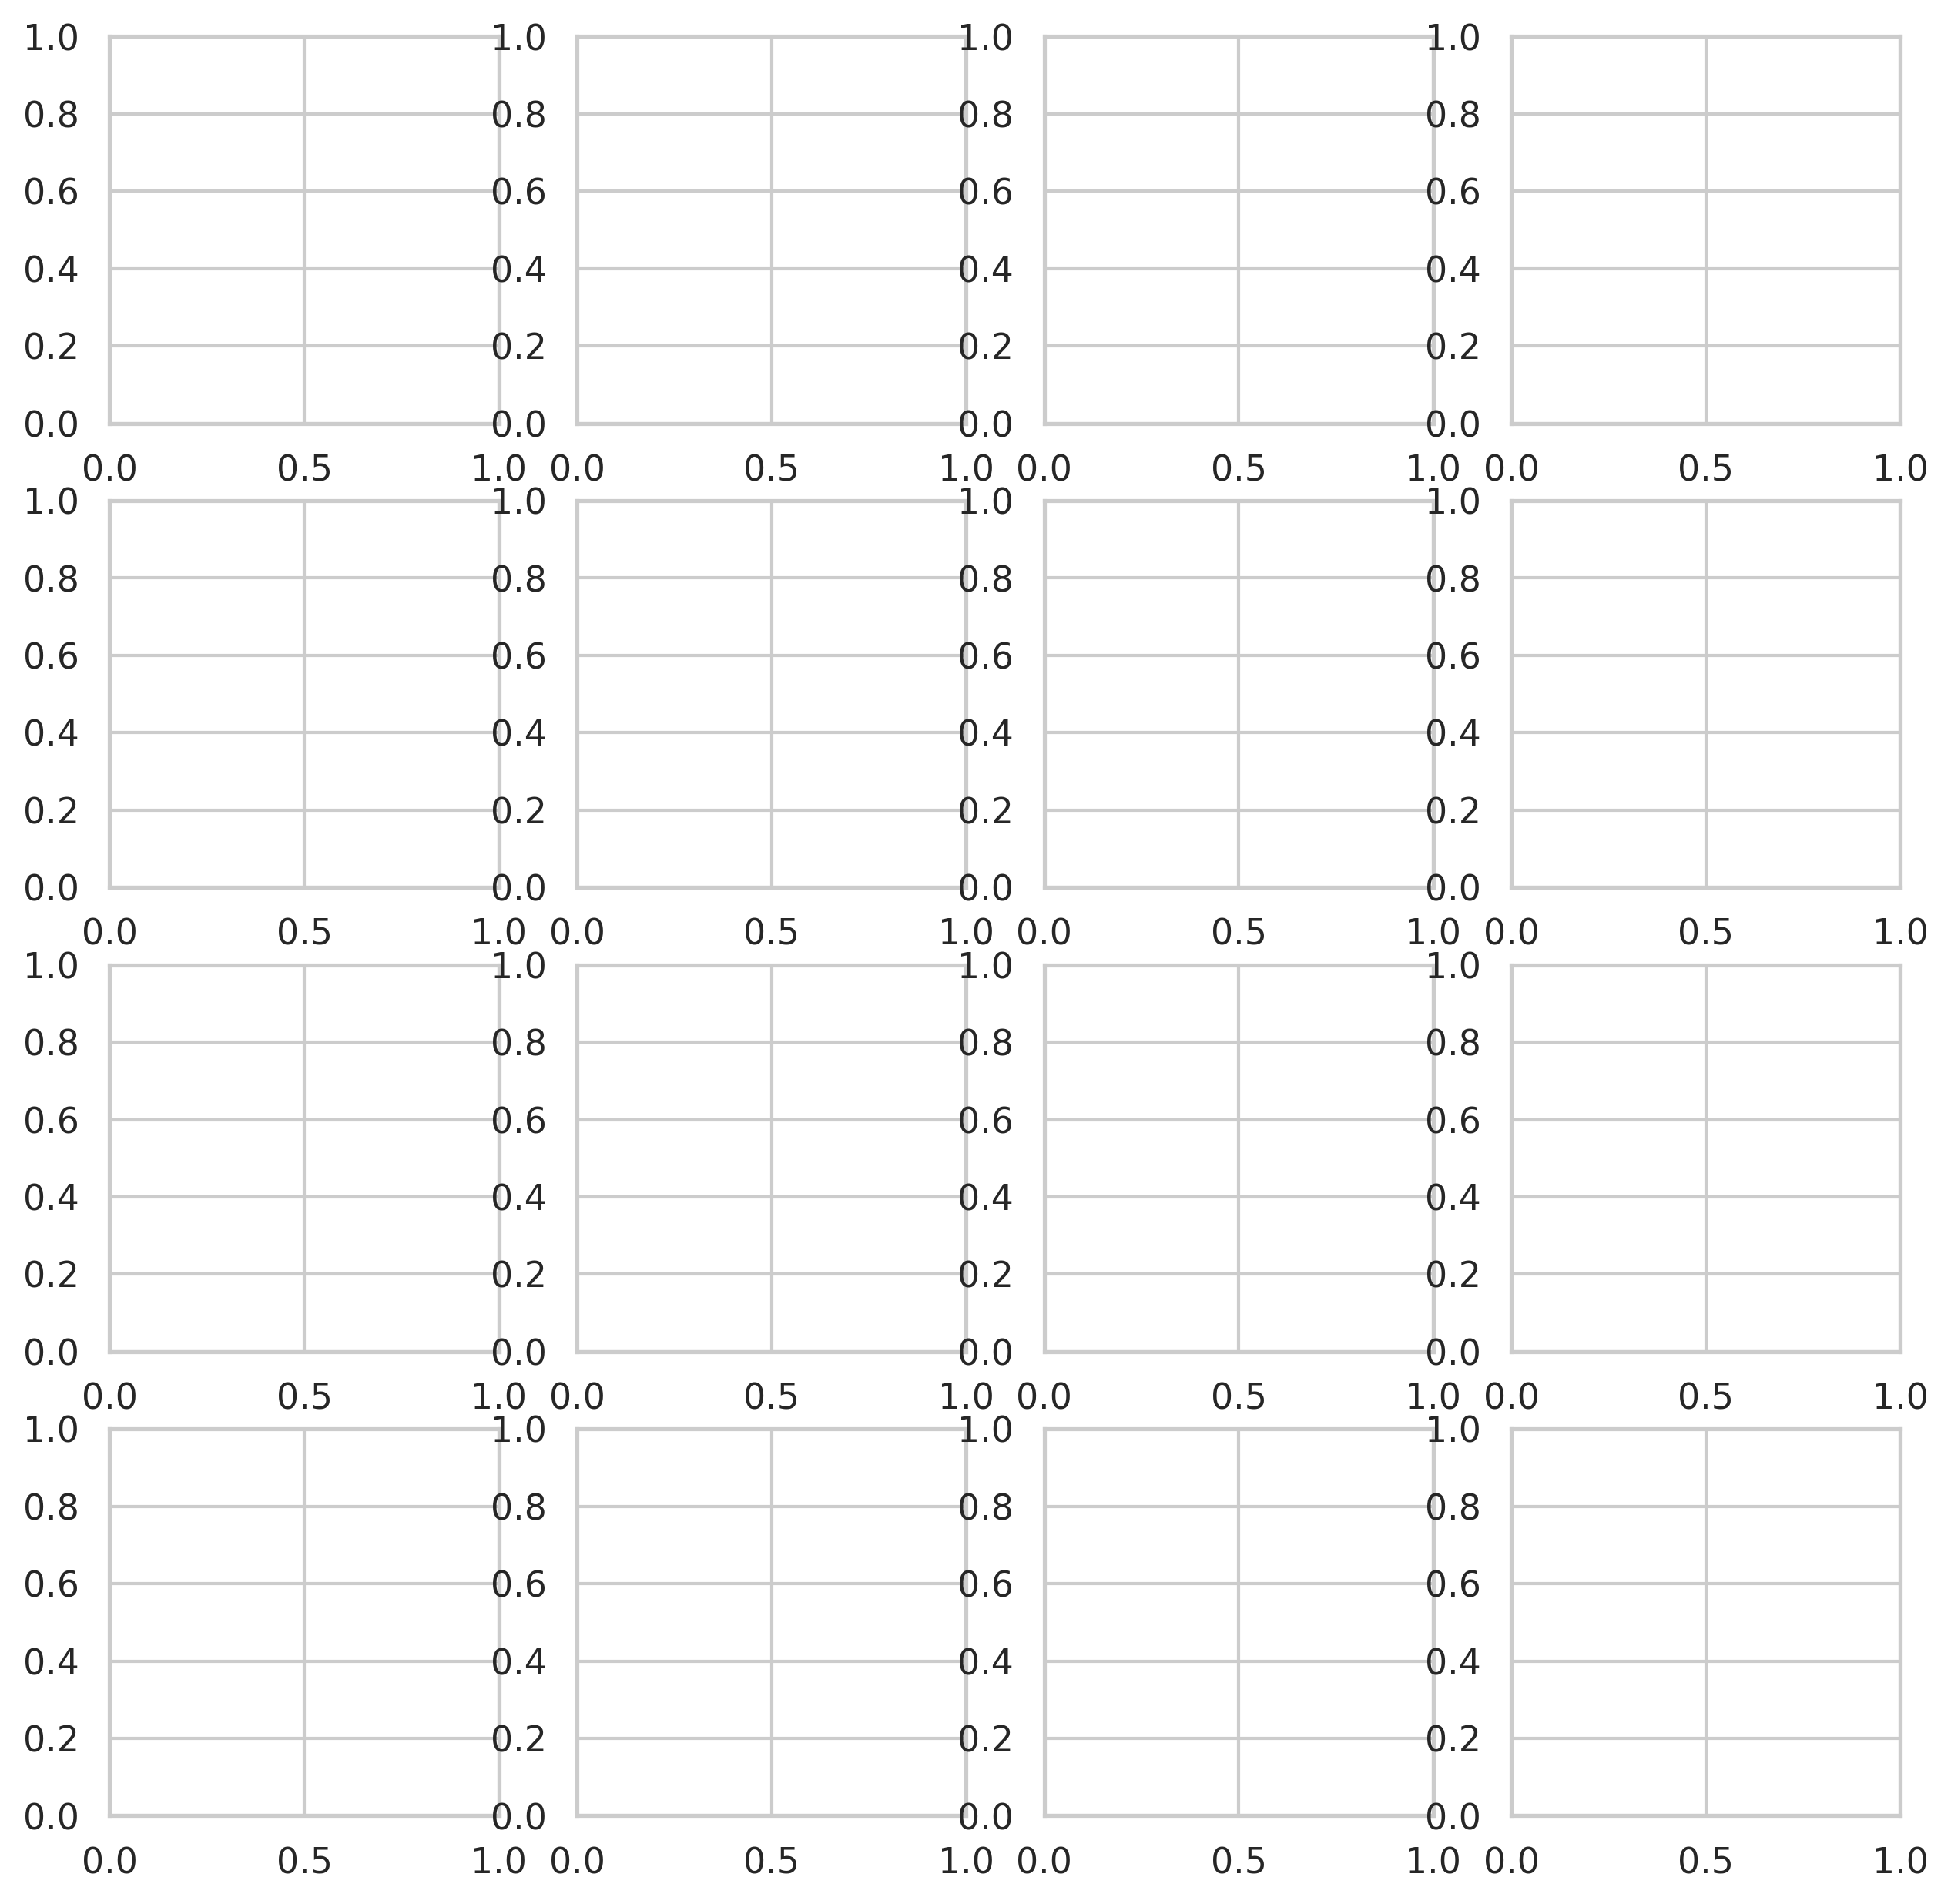

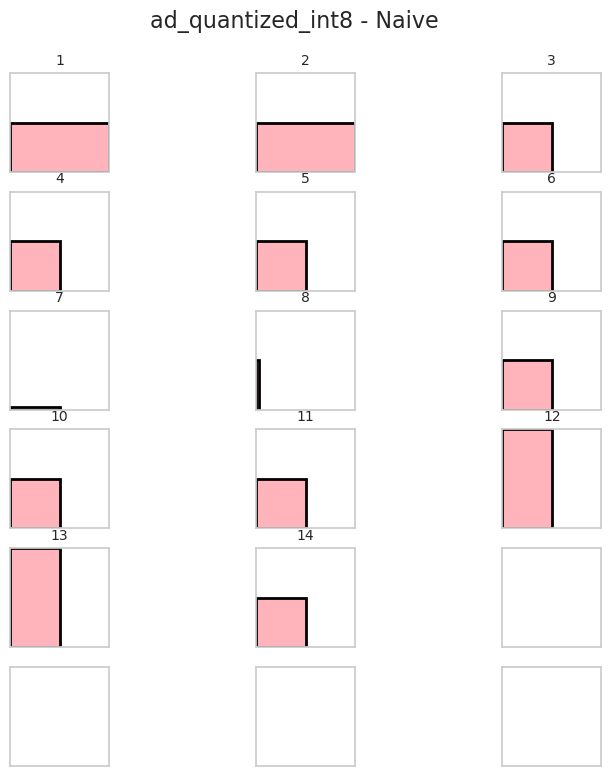

packer is <rectpack.packer.PackerBBF object at 0x7f95240fc5f0>


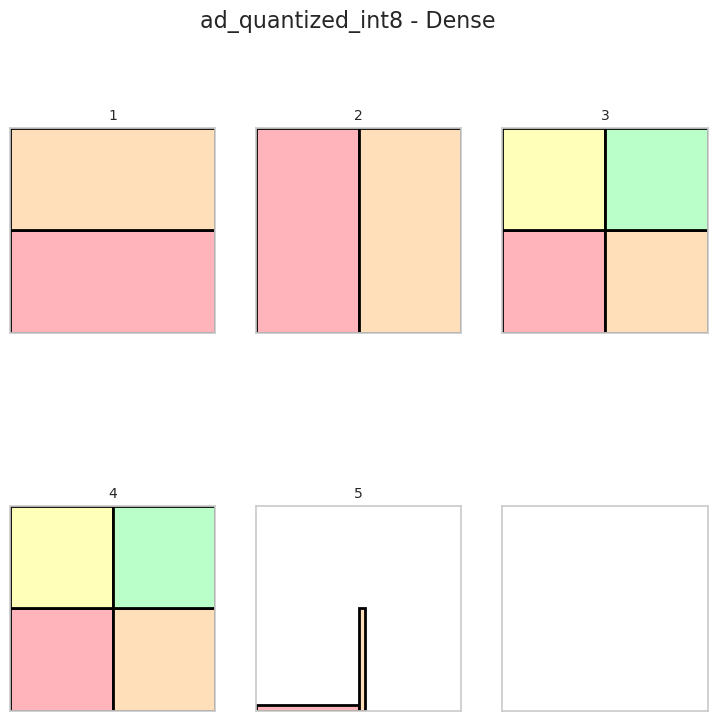

packer is <rectpack.packer.PackerOnlineBBF object at 0x7f951c7ac170>


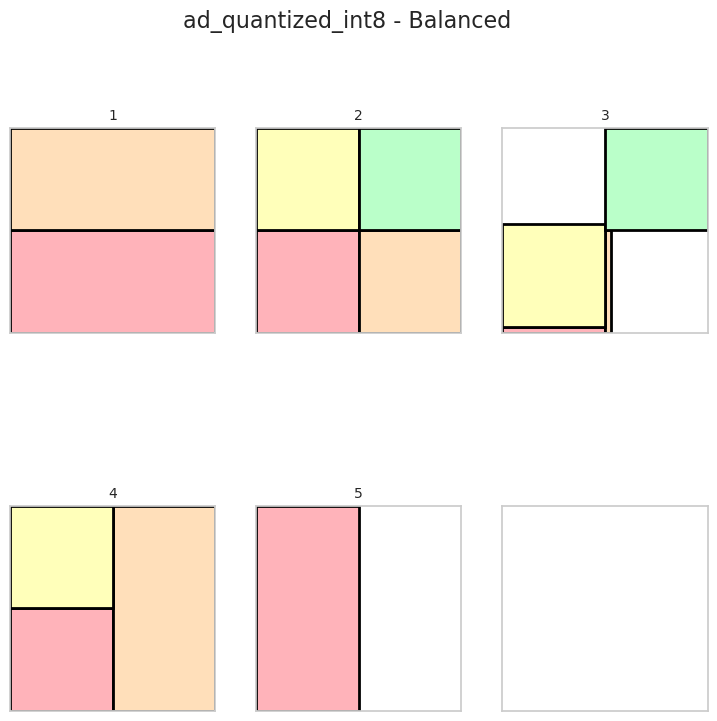

packer is <rectpack.packer.PackerOnlineBNF object at 0x7f951c86c4a0>


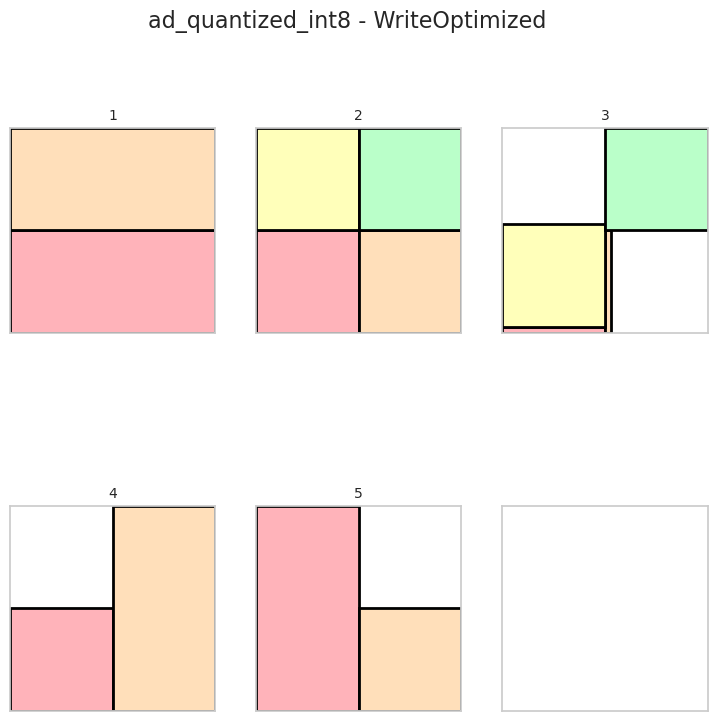

packer is <hwacctools.comp_graph.packer_utils.NaiveRectpackPacker object at 0x7f951c731d00>


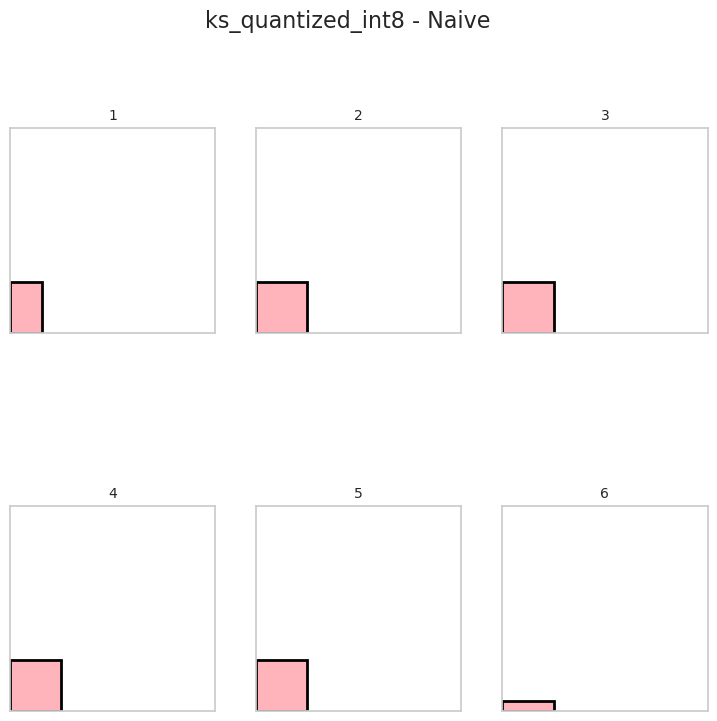

packer is <rectpack.packer.PackerBBF object at 0x7f951c4ec4a0>


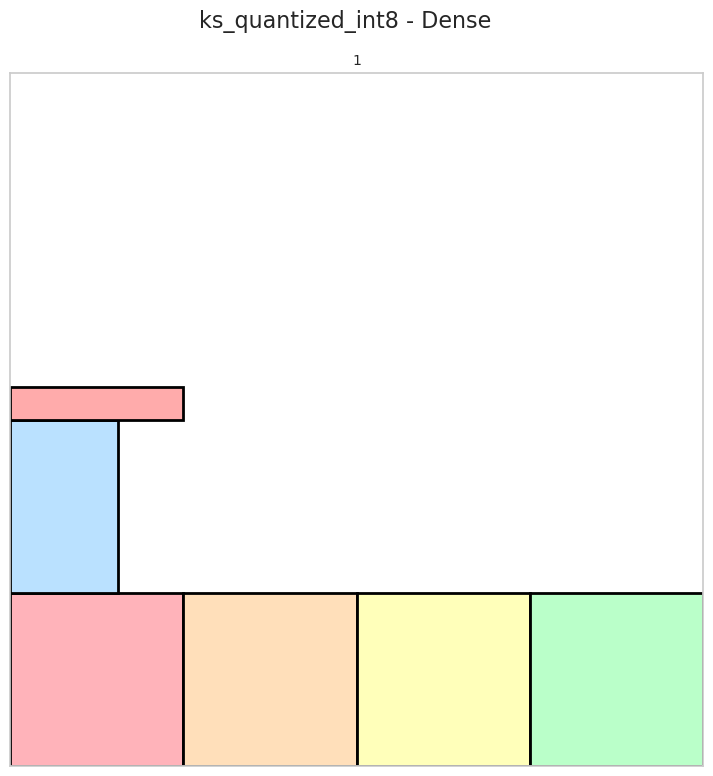

packer is <rectpack.packer.PackerOnlineBBF object at 0x7f951e22fa10>


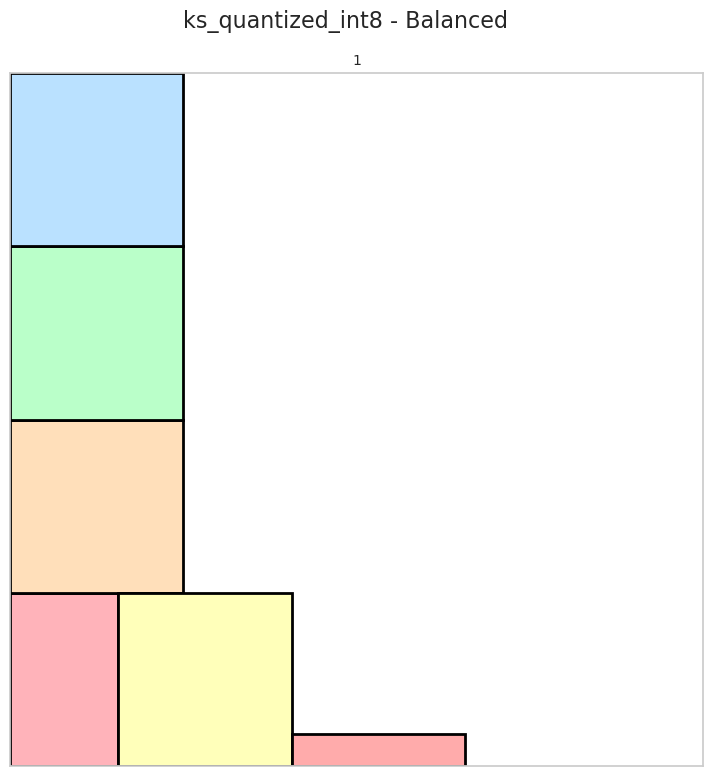

packer is <rectpack.packer.PackerOnlineBNF object at 0x7f95242ea660>


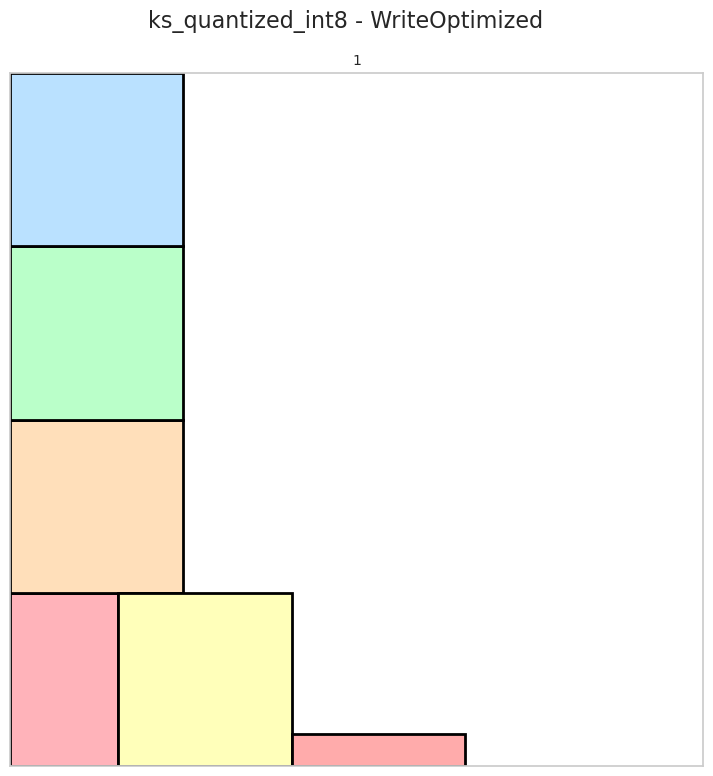

packer is <hwacctools.comp_graph.packer_utils.NaiveRectpackPacker object at 0x7f95240dbe30>


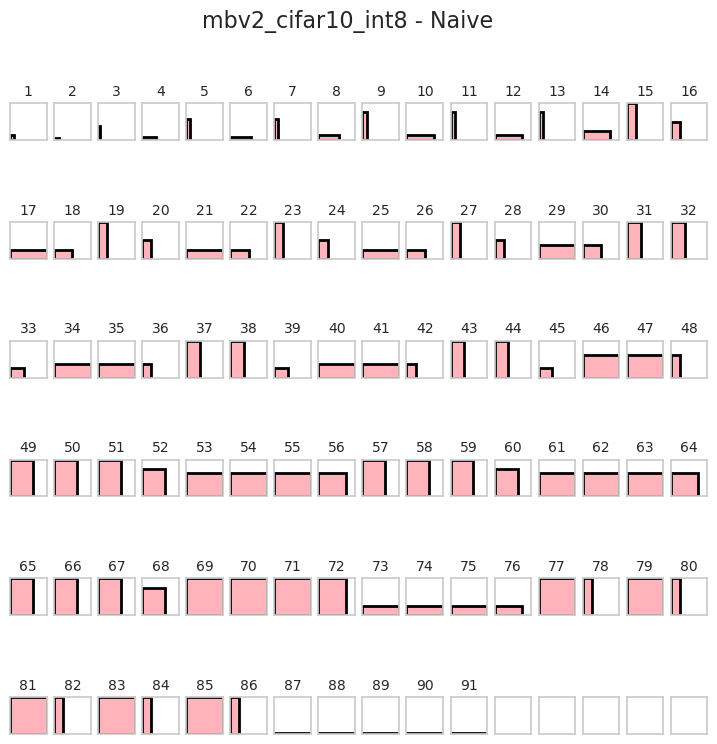

packer is <rectpack.packer.PackerBBF object at 0x7f95241c4170>


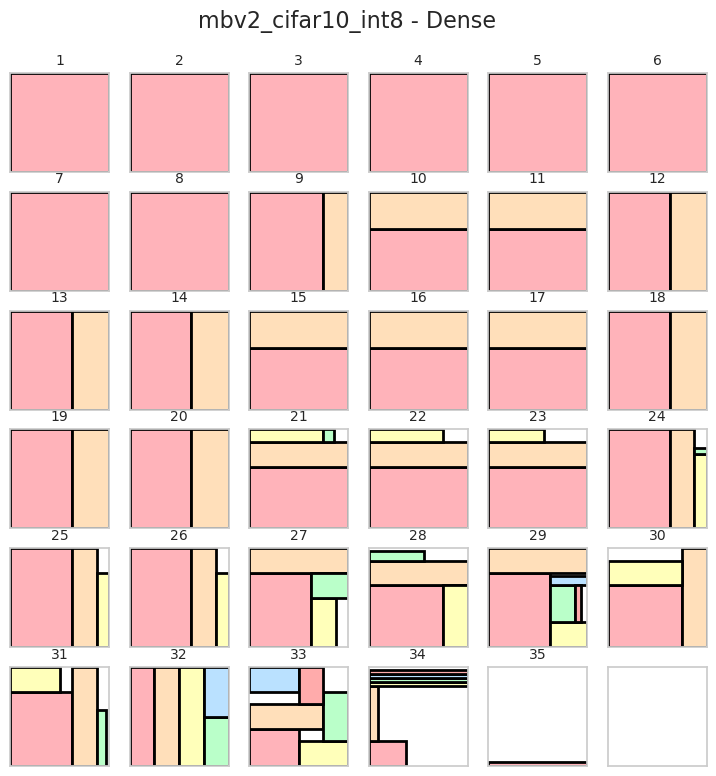

packer is <rectpack.packer.PackerOnlineBBF object at 0x7f95170f3a70>


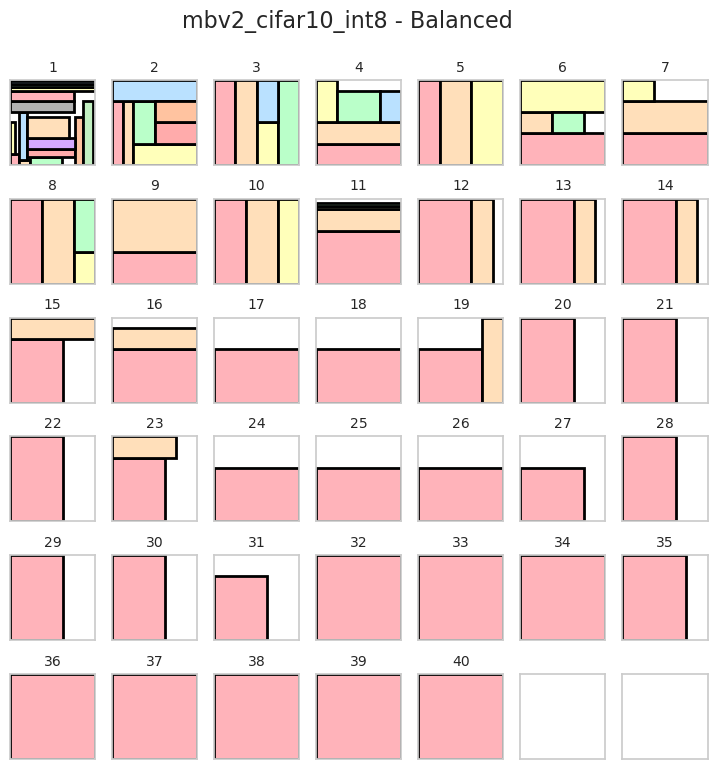

packer is <rectpack.packer.PackerOnlineBNF object at 0x7f9517a3c4a0>


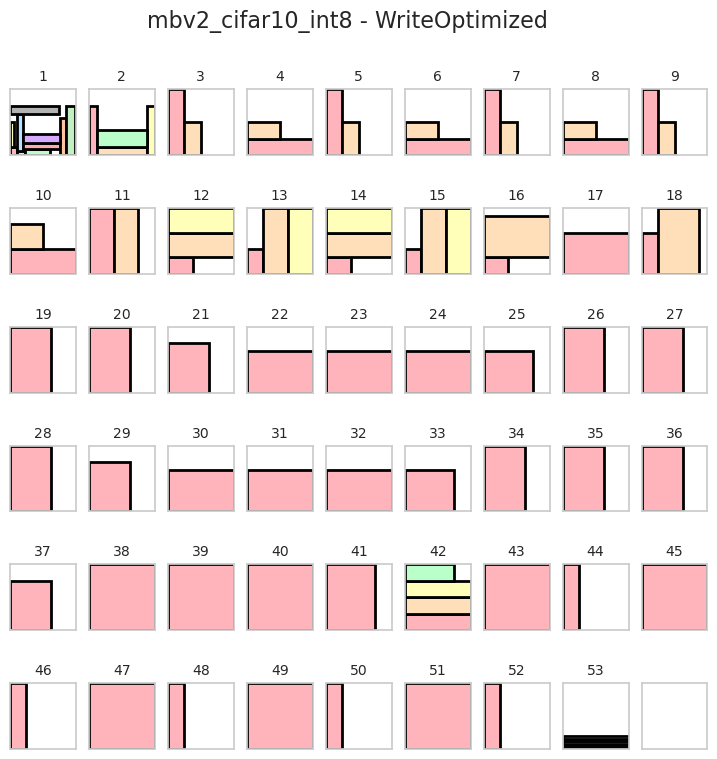

packer is <hwacctools.comp_graph.packer_utils.NaiveRectpackPacker object at 0x7f9517bdfa70>


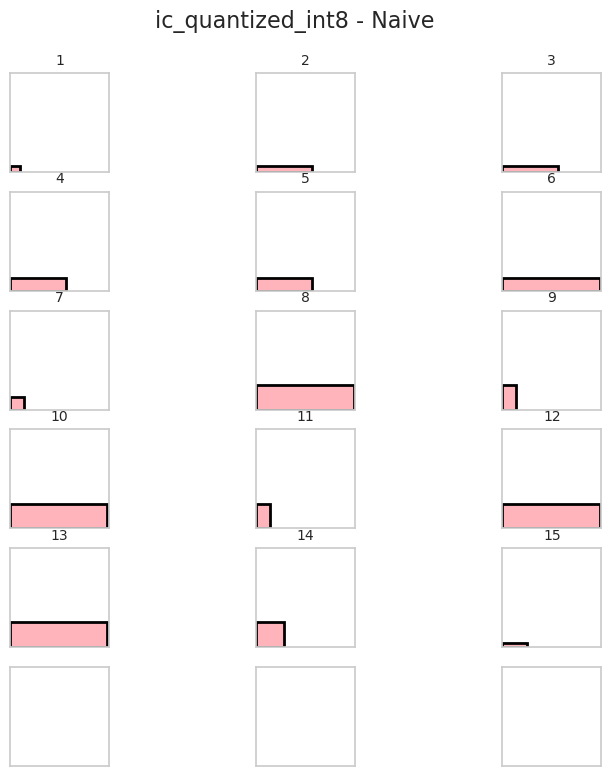

packer is <rectpack.packer.PackerBBF object at 0x7f9517bdd8b0>


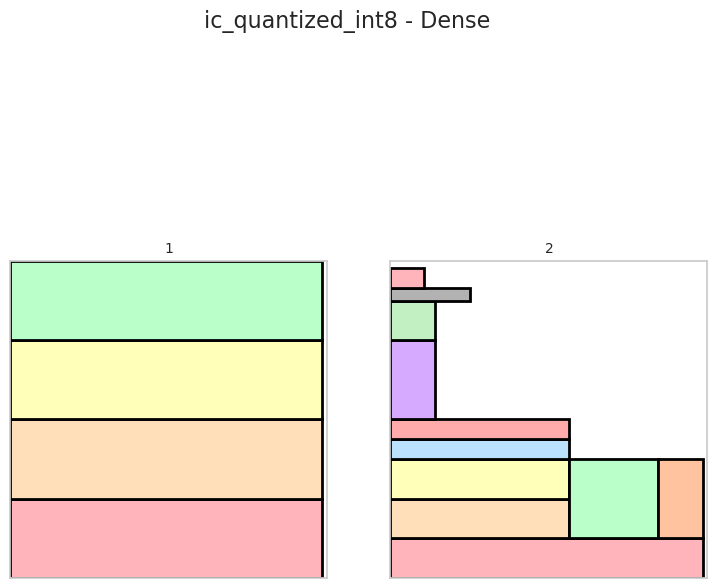

packer is <rectpack.packer.PackerOnlineBBF object at 0x7f9517a71f70>


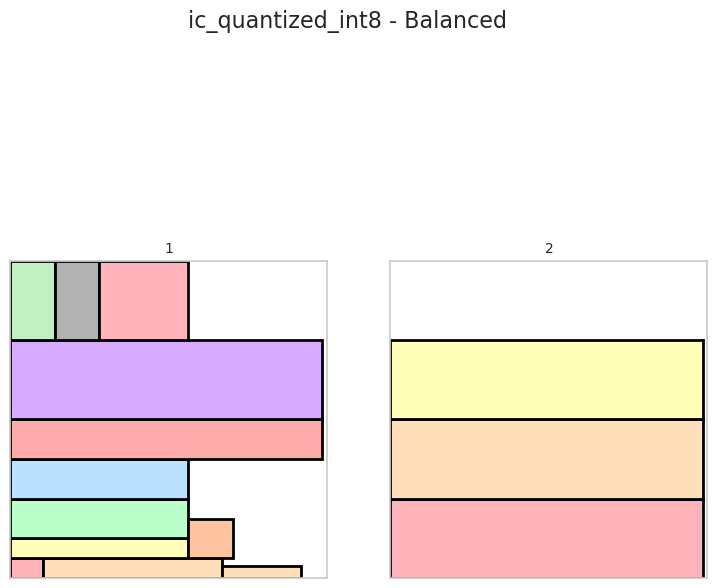

packer is <rectpack.packer.PackerOnlineBNF object at 0x7f95174a1760>


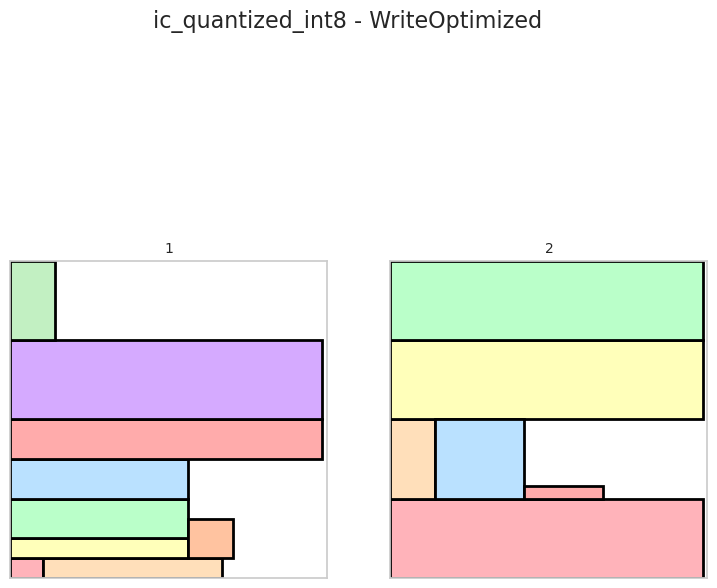

In [18]:
# Setup sweeps for packing experiments

from hwacctools.comp_graph import packer_utils as pu

modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]

packers = ['Naive', 'Dense', 'Balanced', 'WriteOptimized']


core_size = (256, 256)

fig, axs = plt.subplots(4, 4, figsize=(10, 10), dpi=300)

for i, modelpath in enumerate(modelpaths):
    for j, packer_name in enumerate(packers):
        nx_model = onnx.load(modelpath)
        packer = get_packer(packer_name)
        u_marped = core.NxModelMapping(nx_model, imc_core_size=core_size, packer=packer)
        if not u_marped.success:
            print(f"Packing failed for {modelpath} with packer {packer_name}")
            continue

        ax = axs[i, j]
        u_marped.plot(name=f"{modelpath.split('/')[-1].split('.')[0]} - {packer_name}")
        ax.set_title(f"{modelpath.split('/')[-1].split('.')[0]} - {packer_name}")